# Customer Satisfaction Analysis – TechnoServe Solutions
## Factor Analysis • Collaborative Case Study

En este notebook se desarrolla el análisis de satisfacción de clientes para TechnoServe Solutions.
El objetivo es identificar los factores latentes que explican la satisfacción del cliente y evaluar 
su impacto en métricas clave de negocio.


## Integrantes:
### Adrián Tavera Aquino - A01659113
### Daniela Robles Estrada - A01659074
### Elian Alejandro Lopez de Alba - A01659582


# Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from factor_analyzer import FactorAnalyzer, calculate_kmo
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.style.use("seaborn-v0_8")


# 1. Data Exploration and Suitability (Parte 1)

## 1.1 Exploración del Dataset

In [2]:
pd.set_option("display.max_columns", 120)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Cargar el conjunto de datos
df = pd.read_csv("customer_satisfaction_data.csv")


In [3]:
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 3400 non-null   object 
 1   quarter                     3400 non-null   object 
 2   survey_date                 3400 non-null   object 
 3   account_manager_responsive  3384 non-null   float64
 4   billing_accuracy            3387 non-null   float64
 5   budget_control              3383 non-null   float64
 6   change_management           3388 non-null   float64
 7   communication_clarity       3384 non-null   float64
 8   competitive_pricing         3385 non-null   float64
 9   cost_transparency           3390 non-null   float64
 10  documentation_help          3386 non-null   float64
 11  executive_access            3390 non-null   float64
 12  innovation_solutions        3390 non-null   float64
 13  long_term_partnership       3386 

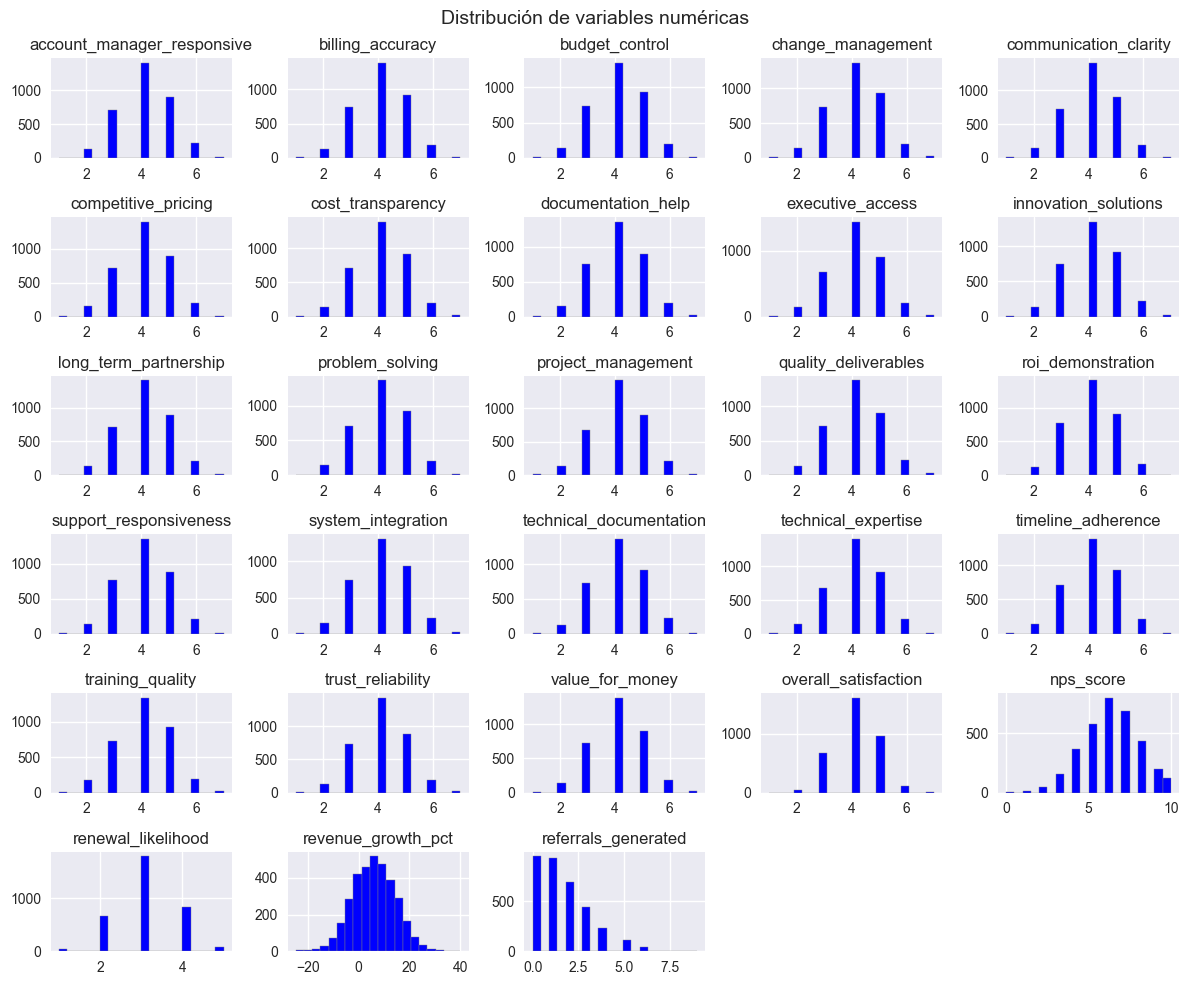

In [4]:
num_cols = df.select_dtypes(exclude=["object"]).columns
df[num_cols].hist(figsize=(12, 10), bins=20, color="blue", edgecolor="grey")
plt.suptitle("Distribución de variables numéricas", fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
# Columnas que NO entran al análisis factorial
id_cols = ["customer_id", "quarter", "survey_date"]

outcome_cols = [
    "overall_satisfaction",
    "nps_score",
    "renewal_likelihood",
    "revenue_growth_pct",
    "referrals_generated"
]


In [6]:
def get_satisfaction_items(df):
    """
    Devuelve la lista de columnas numéricas que se usarán
    en el análisis factorial (ítems de satisfacción).

    - Excluye IDs y fechas (ID_COLS)
    - Excluye variables de resultado (OUTCOME_COLS)
    """
    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns

    satisfaction_cols = [
        c for c in numeric_cols
        if c not in outcome_cols
    ]

    return satisfaction_cols


In [7]:
# Selección consistente de variables de satisfacción

vars_satisfaccion = get_satisfaction_items(df)
print("Número de ítems de satisfacción:", len(vars_satisfaccion))
print(vars_satisfaccion)


Número de ítems de satisfacción: 23
['account_manager_responsive', 'billing_accuracy', 'budget_control', 'change_management', 'communication_clarity', 'competitive_pricing', 'cost_transparency', 'documentation_help', 'executive_access', 'innovation_solutions', 'long_term_partnership', 'problem_solving', 'project_management', 'quality_deliverables', 'roi_demonstration', 'support_responsiveness', 'system_integration', 'technical_documentation', 'technical_expertise', 'timeline_adherence', 'training_quality', 'trust_reliability', 'value_for_money']


In [8]:
# Bloque de datos para el Análisis Factorial 

df_fa = df[vars_satisfaccion].copy()

# Imputación simple: media por columna (faltantes <1%)
df_fa = df_fa.fillna(df_fa.mean(numeric_only=True))

# Verificación final de nulos
df_fa.isnull().sum().sum(), df_fa.shape


(np.int64(0), (3400, 23))

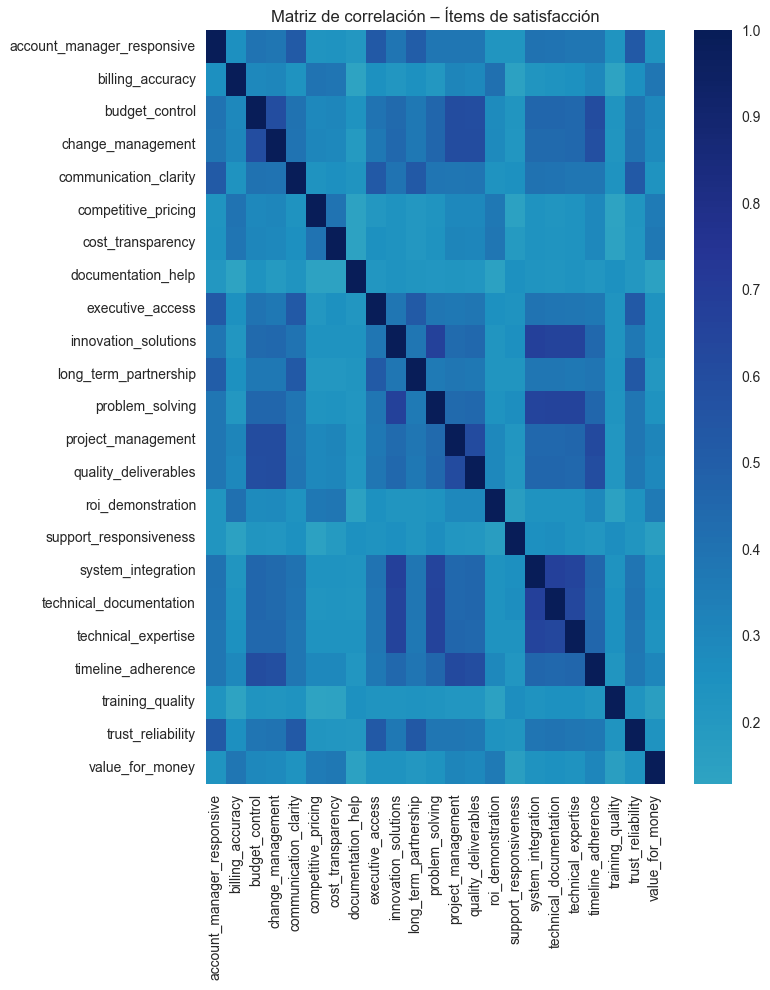

In [9]:
# Matriz de correlación de ítems de satisfacción

plt.figure(figsize=(8, 10))
matriz_corr = df[vars_satisfaccion].corr()

sns.heatmap(
    matriz_corr,
    annot=False,
    cmap="YlGnBu",
    center=0
)
plt.title("Matriz de correlación – Ítems de satisfacción")
plt.tight_layout()
plt.show()


## 1.2 Factor Analysis Suitability

In [10]:
# !pip install factor_analyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# KMO (adecuación muestral) y Bartlett (esfericidad)
kmo_all, kmo_model = calculate_kmo(df_fa)
print(f"KMO global: {kmo_model:.3f}")

chi_square_value, p_value = calculate_bartlett_sphericity(df_fa)
print(f"Bartlett's test: Chi2 = {chi_square_value:.2f}, p-value = {p_value:.10f}  (Regla: p<0.05)")

KMO global: 0.959
Bartlett's test: Chi2 = 34357.04, p-value = 0.0000000000  (Regla: p<0.05)


KMO global = 0.959 → Excelente (muy por encima del mínimo recomendado de 0.60).

Bartlett p < 0.001 → La matriz de correlaciones es significativamente diferente a una identidad.

Los resultados indican que los datos son altamente adecuados para aplicar análisis factorial.
El índice KMO = 0.959 confirma una excelente adecuación muestral y la prueba de Bartlett (p < 0.001)
demuestra que las correlaciones entre variables son estadísticamente significativas. Por lo tanto,
la estructura de los datos sí puede explicarse mediante factores latentes.

# 2. Factor Extraction and Determination (Parte 2)

## 2.1 Determining the Number of Factors

c:\Users\atave\anaconda3\envs\IDM\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


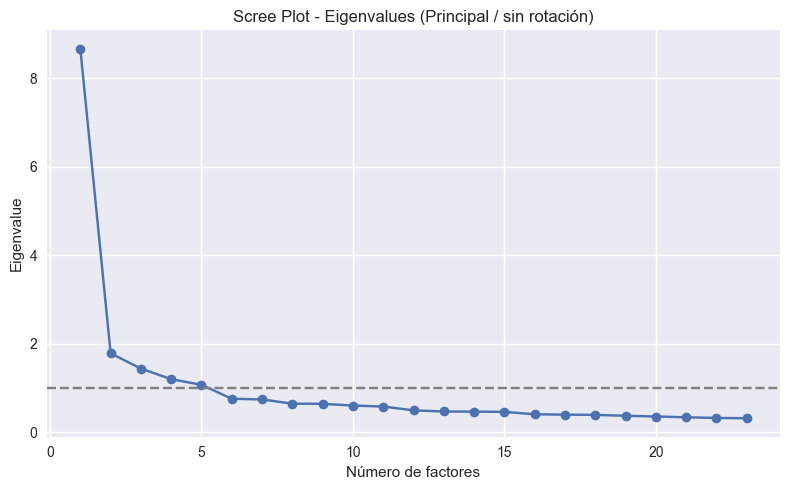

,Factor,Eigenvalue
0,1,8.660840
1,2,1.786282
2,3,1.442320
3,4,1.202009
4,5,1.075362
5,6,0.760207
6,7,0.745188
7,8,0.649726
8,9,0.646346
9,10,0.607249


In [11]:
n_vars = df_fa.shape[1]

fa_ev = FactorAnalyzer(n_factors=n_vars, method='principal', rotation=None)
fa_ev.fit(df_fa)

eigenvalues, _ = fa_ev.get_eigenvalues()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o')
plt.axhline(1, color='gray', linestyle='--')
plt.title("Scree Plot - Eigenvalues (Principal / sin rotación)")
plt.xlabel("Número de factores")
plt.ylabel("Eigenvalue")
plt.tight_layout()
plt.show()

eigs_table = pd.DataFrame({
    "Factor": range(1, len(eigenvalues)+1),
    "Eigenvalue": eigenvalues
})
eigs_table.head(10)


## 2.2 PCA vs ML y Varimax vs Promax

In [12]:
modelos = []

def evaluar_modelo(nombre, n_factors, method, rotation):
    """
    Ajusta un modelo de FactorAnalyzer y guarda la varianza explicada.
    """
    fa = FactorAnalyzer(n_factors=n_factors, method=method, rotation=rotation)
    fa.fit(df_fa)
    var, prop_var, cum_var = fa.get_factor_variance()
    
    modelos.append({
        "Modelo": nombre,
        "Factores": n_factors,
        "Método": method,
        "Rotación": rotation,
        "Varianza_exp_total": prop_var.sum()
    })
    return fa

# 3 FACTORES

fa3_pca_var = evaluar_modelo("3F - PCA Varimax", 3, "principal", "varimax")
fa3_pca_pro = evaluar_modelo("3F - PCA Promax",  3, "principal", "promax")
fa3_ml_var  = evaluar_modelo("3F - ML Varimax",  3, "ml",        "varimax")
fa3_ml_pro  = evaluar_modelo("3F - ML Promax",   3, "ml",        "promax")

# 5 FACTORES

fa5_pca_var = evaluar_modelo("5F - PCA Varimax", 5, "principal", "varimax")
fa5_pca_pro = evaluar_modelo("5F - PCA Promax",  5, "principal", "promax")
fa5_ml_var  = evaluar_modelo("5F - ML Varimax",  5, "ml",        "varimax")
fa5_ml_pro  = evaluar_modelo("5F - ML Promax",   5, "ml",        "promax")  

resumen_modelos = pd.DataFrame(modelos)



c:\Users\atave\anaconda3\envs\IDM\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\atave\anaconda3\envs\IDM\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\atave\anaconda3\envs\IDM\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\atave\anaconda3\envs\IDM\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\atave\anaconda3\envs\IDM\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

In [13]:
resumen_modelos

,Modelo,Factores,Método,Rotación,Varianza_exp_total
0,3F - PCA Varimax,3,principal,varimax,0.516929
1,3F - PCA Promax,3,principal,promax,0.526364
2,3F - ML Varimax,3,ml,varimax,0.444298
3,3F - ML Promax,3,ml,promax,0.433031
4,5F - PCA Varimax,5,principal,varimax,0.615948
5,5F - PCA Promax,5,principal,promax,0.604385
6,5F - ML Varimax,5,ml,varimax,0.503878
7,5F - ML Promax,5,ml,promax,0.482609


## 2.3 Final Model: 5 factores

### **Para comparar, una matríz de correlación de los modelos 5F- ML PROMAX vs 5F- PCA Varimax**

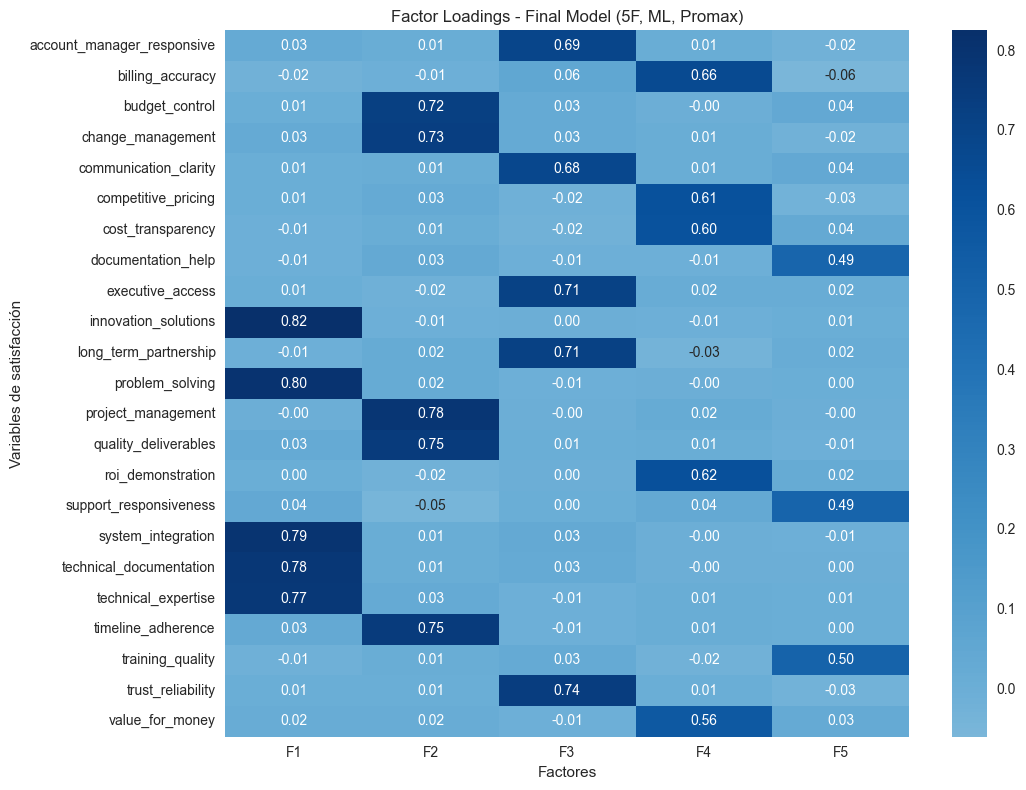

,Varianza,Proporción,Acumulada
F1,3.156406,0.137235,0.137235
F2,2.803361,0.121885,0.259120
F3,2.511677,0.109203,0.368324
F4,1.881844,0.081819,0.450143
F5,0.746716,0.032466,0.482609


In [14]:
# Matriz de cargas factoriales
loadings = pd.DataFrame(
    fa5_ml_pro.loadings_,
    index=df_fa.columns,
    columns=["F1", "F2", "F3", "F4", "F5"]  # luego puedes renombrarlos según la interpretación
)

plt.figure(figsize=(11, 8))
sns.heatmap(loadings, annot=True, cmap="Blues", center=0, fmt=".2f")
plt.title("Factor Loadings - Final Model (5F, ML, Promax)")
plt.xlabel("Factores")
plt.ylabel("Variables de satisfacción")
plt.tight_layout()
plt.show()

# Varianza explicada del modelo final
var_final, prop_var_final, cum_var_final = fa5_ml_pro.get_factor_variance()
pd.DataFrame({
    "Varianza": var_final,
    "Proporción": prop_var_final,
    "Acumulada": cum_var_final
}, index=["F1","F2","F3","F4","F5"])


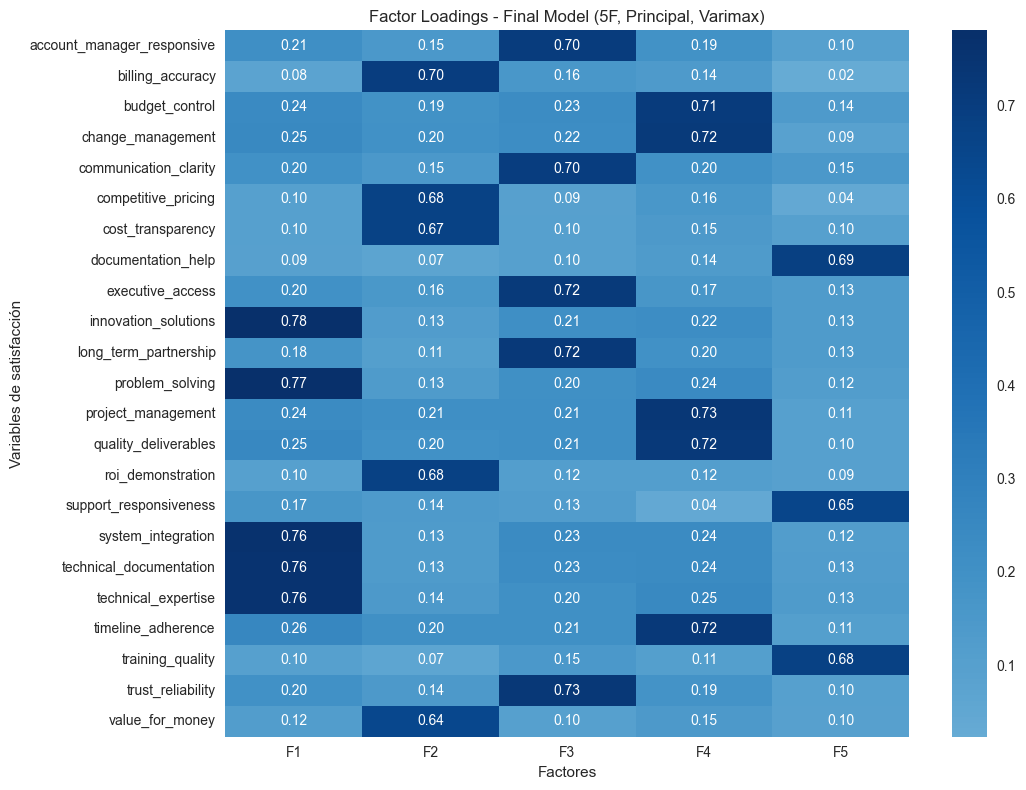

,Varianza,Proporción,Acumulada
F1,3.539219,0.153879,0.153879
F2,2.698229,0.117314,0.271193
F3,3.133549,0.136241,0.407435
F4,3.194108,0.138874,0.546309
F5,1.601698,0.069639,0.615948


In [15]:
# Matriz de cargas factoriales
loadings = pd.DataFrame(
    fa5_pca_var.loadings_,
    index=df_fa.columns,
    columns=["F1", "F2", "F3", "F4", "F5"]  # luego puedes renombrarlos según la interpretación
)

plt.figure(figsize=(11, 8))
sns.heatmap(loadings, annot=True, cmap="Blues", center=0, fmt=".2f")
plt.title("Factor Loadings - Final Model (5F, Principal, Varimax)")
plt.xlabel("Factores")
plt.ylabel("Variables de satisfacción")
plt.tight_layout()
plt.show()

# Varianza explicada del modelo final
var_final, prop_var_final, cum_var_final = fa5_pca_var.get_factor_variance()
pd.DataFrame({
    "Varianza": var_final,
    "Proporción": prop_var_final,
    "Acumulada": cum_var_final
}, index=["F1","F2","F3","F4","F5"])


c:\Users\atave\anaconda3\envs\IDM\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


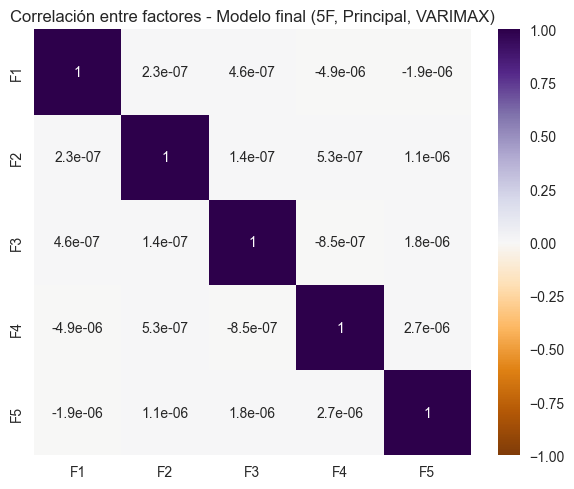

In [16]:
factor_scores_tmp = fa5_pca_var.transform(df_fa)
factor_scores_tmp = pd.DataFrame(factor_scores_tmp, columns=["F1","F2","F3","F4","F5"])

plt.figure(figsize=(6, 5))
sns.heatmap(factor_scores_tmp.corr(), annot=True, cmap="PuOr", vmin=-1, vmax=1)
plt.title("Correlación entre factores - Modelo final (5F, Principal, VARIMAX)")
plt.tight_layout()
plt.show()



c:\Users\atave\anaconda3\envs\IDM\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


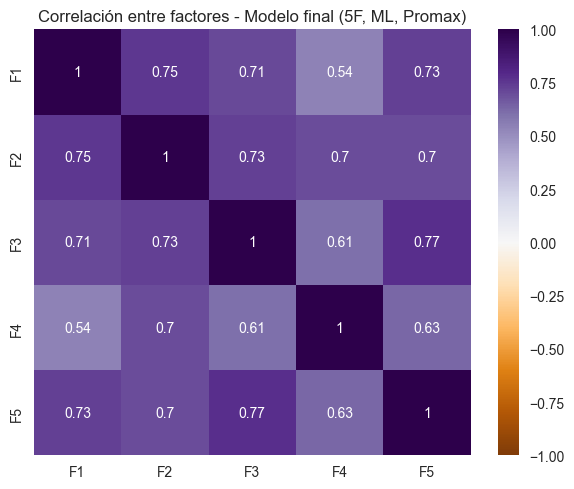

FactorAnalyzer(method='ml', n_factors=5, rotation_kwargs={})

In [17]:


factor_scores_tmp = fa5_ml_pro.transform(df_fa)
factor_scores_tmp = pd.DataFrame(factor_scores_tmp, columns=["F1","F2","F3","F4","F5"])

plt.figure(figsize=(6, 5))
sns.heatmap(factor_scores_tmp.corr(), annot=True, cmap="PuOr", vmin=-1, vmax=1)
plt.title("Correlación entre factores - Modelo final (5F, ML, Promax)")
plt.tight_layout()
plt.show()

fa5_ml_pro

### **Comparación de modelos y selección final**

Se compararon ocho configuraciones del análisis factorial combinando:
**dos métodos de extracción** (PCA y ML), **dos rotaciones** (Varimax y Promax)
y **dos tamaños de solución** (3 y 5 factores).

El criterio principal para elegir el modelo final, siguiendo las recomendaciones del profesor, fue la **varianza explicada total**.
La comparación muestra que el modelo **5F – PCA – Varimax** es el que mejor desempeño obtiene, alcanzando la mayor proporción de varianza explicada (~61.6%), por encima de todas las otras combinaciones evaluadas.

Aunque algunos métodos (como ML con rotación Promax) permiten que los factores estén correlacionados, en este caso **no es un requisito metodológico**, ya que el propósito del proyecto es **segmentar los ítems de satisfacción en dimensiones claras y accionables**, no modelar relaciones psicométricas entre constructos.

Desde la perspectiva del negocio, lo más importante es obtener **factores estables, interpretables y útiles para priorizar estrategias**, y no necesariamente que las dimensiones sean dependientes entre sí.
En este sentido, la rotación **Varimax** ofrece una ventaja práctica: genera factores ortogonales y más fáciles de comunicar, sin comprometer el objetivo analítico.

**Conclusión:**
El modelo final seleccionado para continuar con la interpretación y el análisis predictivo es:
**5 Factores – Método PCA – Rotación Varimax**,
debido a que maximiza la varianza explicada y facilita una interpretación clara para la toma de decisiones.


In [18]:
# Obtener la matriz de cargas factoriales del modelo seleccionado
loadings_5F = pd.DataFrame(
    fa5_pca_var.loadings_,
    index=df_fa.columns,
    columns=["F1", "F2", "F3", "F4", "F5"]
)


In [19]:
THR = 0.40  

variables_por_factor = {
    f: loadings_5F[abs(loadings_5F[f]) >= THR][f].sort_values(ascending=False)
    for f in loadings_5F.columns
}




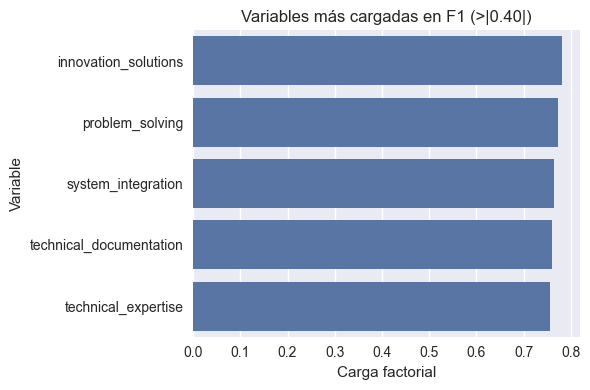

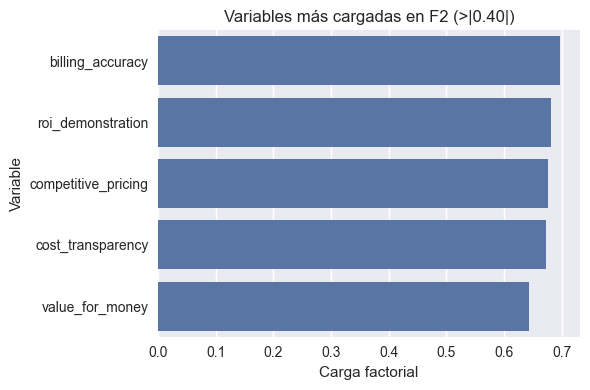

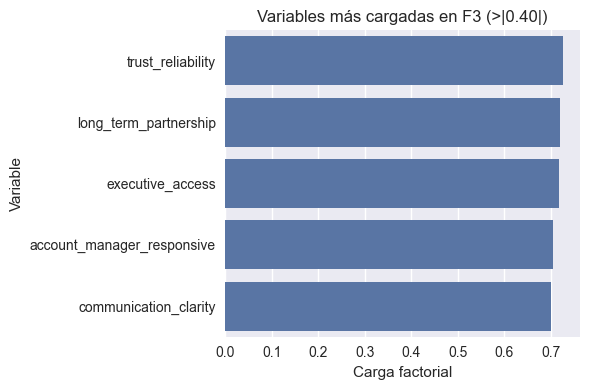

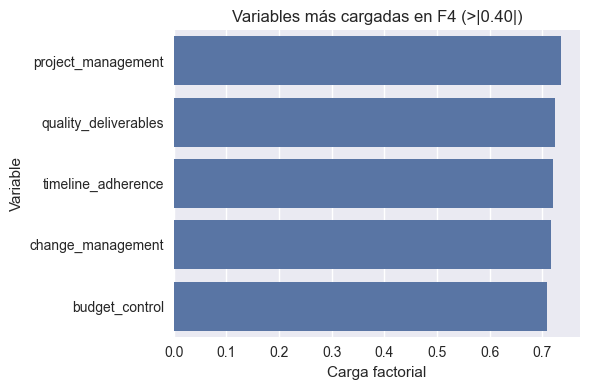

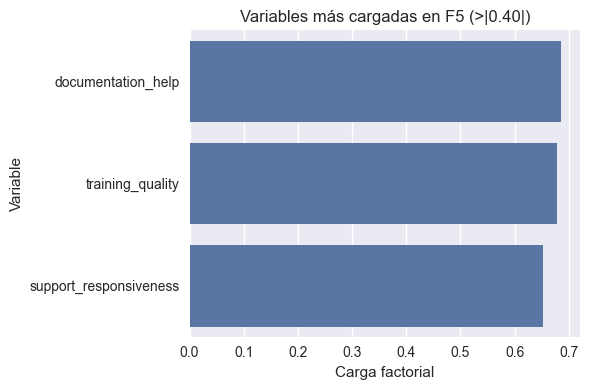

In [20]:
for factor, serie in variables_por_factor.items():
    plt.figure(figsize=(6, 4))
    sns.barplot(x=serie.values, y=serie.index, orient='h')
    plt.title(f"Variables más cargadas en {factor} (>|0.40|)")
    plt.xlabel("Carga factorial")
    plt.ylabel("Variable")
    plt.tight_layout()
    plt.show()


In [21]:
for factor, serie in variables_por_factor.items():
    print(f"\n=== {factor} ===")
    for var, carga in serie.items():
        print(f" - {var} (carga = {carga:.2f})")



=== F1 ===
 - innovation_solutions (carga = 0.78)
 - problem_solving (carga = 0.77)
 - system_integration (carga = 0.76)
 - technical_documentation (carga = 0.76)
 - technical_expertise (carga = 0.76)

=== F2 ===
 - billing_accuracy (carga = 0.70)
 - roi_demonstration (carga = 0.68)
 - competitive_pricing (carga = 0.68)
 - cost_transparency (carga = 0.67)
 - value_for_money (carga = 0.64)

=== F3 ===
 - trust_reliability (carga = 0.73)
 - long_term_partnership (carga = 0.72)
 - executive_access (carga = 0.72)
 - account_manager_responsive (carga = 0.70)
 - communication_clarity (carga = 0.70)

=== F4 ===
 - project_management (carga = 0.73)
 - quality_deliverables (carga = 0.72)
 - timeline_adherence (carga = 0.72)
 - change_management (carga = 0.72)
 - budget_control (carga = 0.71)

=== F5 ===
 - documentation_help (carga = 0.69)
 - training_quality (carga = 0.68)
 - support_responsiveness (carga = 0.65)


# 2.4 Interpretación de los Factores (Modelo 5F – Principal Varimax)


A partir de la matriz de cargas factoriales y aplicando un umbral de ≥ |0.40|, se identificaron cinco dimensiones principales dentro del conjunto de 23 ítems de satisfacción. Cada factor agrupa variables que comparten un patrón conceptual claro, lo cual permite traducir los resultados técnicos en elementos estratégicos para la toma de decisiones.

---

## **Factor 1 – Capacidad Técnica e Innovación**

**Variables con cargas altas:**
innovation_solutions, problem_solving, system_integration, technical_documentation, technical_expertise.

**Interpretación:**
Este factor representa la competencia técnica del proveedor y su capacidad para ofrecer soluciones innovadoras y bien ejecutadas. Incluye aspectos como la integración técnica, la documentación, la experiencia del equipo y la habilidad para resolver problemas. En términos de negocio, este factor resume el desempeño técnico y la capacidad del proveedor para entregar soluciones de alta calidad.

---

## **Factor 2 – Valor Financiero y Transparencia**

**Variables con cargas altas:**
billing_accuracy, roi_demonstration, competitive_pricing, cost_transparency, value_for_money.

**Interpretación:**
Este factor captura la percepción financiera del cliente respecto al servicio recibido. Se relaciona con la transparencia en los costos, la precisión en la facturación, la claridad para demostrar retorno de inversión y la competitividad del precio. Representa el grado en que el cliente siente que obtiene un valor adecuado por el costo pagado.

---

## **Factor 3 – Relación Comercial y Gestión de Cuenta**

**Variables con cargas altas:**
trust_reliability, long_term_partnership, executive_access, account_manager_responsive, communication_clarity.

**Interpretación:**
Este factor reúne elementos relacionados con la confianza, la claridad en la comunicación y la calidad del manejo de la relación comercial. Incluye el acceso a ejecutivos clave, la capacidad de respuesta del account manager y la percepción de una relación orientada al largo plazo. En la práctica, este factor refleja la solidez de la relación comercial y el nivel de cercanía estratégica entre cliente y proveedor.

---

## **Factor 4 – Gestión de Proyectos y Cumplimiento Operativo**

**Variables con cargas altas:**
project_management, quality_deliverables, timeline_adherence, change_management, budget_control.

**Interpretación:**
Este factor describe la capacidad del proveedor para administrar proyectos de forma eficiente, cumplir con tiempos establecidos, manejar adecuadamente los cambios y asegurar la calidad de los entregables. Representa la disciplina operativa y la consistencia en la ejecución del servicio. Para el negocio, este factor indica qué tan confiable es el proveedor en términos de planificación y entrega.

---

## **Factor 5 – Soporte Operativo y Capacitación**

**Variables con cargas altas:**
documentation_help, training_quality, support_responsiveness.

**Interpretación:**
El quinto factor agrupa elementos asociados al soporte posterior a la implementación. Incluye la calidad del entrenamiento, la utilidad de la documentación y la capacidad de respuesta del equipo de soporte. Este factor mide qué tan acompañado y capacitado se siente el cliente para utilizar la solución de manera efectiva.

---

## **Resumen General de Factores**

| Factor                                          | Descripción                                                             |
| ----------------------------------------------- | ----------------------------------------------------------------------- |
| **F1 – Capacidad Técnica e Innovación**         | Experiencia técnica, integración, innovación y resolución de problemas. |
| **F2 – Valor Financiero y Transparencia**       | Percepción de costos, competitividad y retorno de inversión.            |
| **F3 – Relación Comercial y Gestión de Cuenta** | Confianza, comunicación clara y manejo estratégico de la relación.      |
| **F4 – Gestión de Proyectos y Cumplimiento**    | Planificación, calidad y disciplina operativa.                          |
| **F5 – Soporte Operativo y Capacitación**       | Documentación, entrenamiento y capacidad de respuesta.                  |



# 3. Cálculo de Factor Scores (Modelo 5F – Principal Varimax)

Los factor scores permiten cuantificar el nivel de cada factor para cada observación (cliente). Estos valores sintetizan los 23 ítems originales en cinco dimensiones interpretable que se utilizarán posteriormente para analizar su relación con las métricas de negocio.

In [22]:
# Calcular factor scores usando el modelo final
scores_5F = fa5_pca_var.transform(df_fa)

# Convertir a DataFrame
scores_5F = pd.DataFrame(
    scores_5F,
    columns=["F1", "F2", "F3", "F4", "F5"]
)

scores_5F.head()


c:\Users\atave\anaconda3\envs\IDM\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,F1,F2,F3,F4,F5
0,0.293904,1.975651,1.129433,-0.403103,-1.147604
1,-0.621765,-1.256184,1.840853,0.312896,-1.169375
2,-0.721993,-0.908603,0.393442,-0.168060,-0.872081
3,0.050298,-0.385452,-1.954821,0.167987,-1.193823
4,0.824128,-0.490369,1.075260,0.480793,-0.036415


## 3.2 Integrar los factor scores al dataset original

In [23]:
df_scores = pd.concat([scores_5F, df[[
    "overall_satisfaction",
    "nps_score",
    "renewal_likelihood",
    "revenue_growth_pct"
]].reset_index(drop=True)], axis=1)

df_scores.head()


,F1,F2,F3,F4,F5,overall_satisfaction,nps_score,renewal_likelihood,revenue_growth_pct
0,0.293904,1.975651,1.129433,-0.403103,-1.147604,4,6,4,12.3
1,-0.621765,-1.256184,1.840853,0.312896,-1.169375,4,5,3,17.8
2,-0.721993,-0.908603,0.393442,-0.168060,-0.872081,3,4,3,-7.8
3,0.050298,-0.385452,-1.954821,0.167987,-1.193823,4,5,2,-13.4
4,0.824128,-0.490369,1.075260,0.480793,-0.036415,5,5,4,3.7


## 4. Relación entre Factores y Métricas de Negocio

En esta sección se evalúa cómo los cinco factores identificados (satisfacción técnica, valor financiero, relación comercial, gestión operativa y soporte) se relacionan con las métricas clave del negocio:

- overall_satisfaction

- nps_score

- renewal_likelihood

- revenue_growth_pct

Esto permite identificar qué dimensiones del servicio impulsan más el desempeño general.

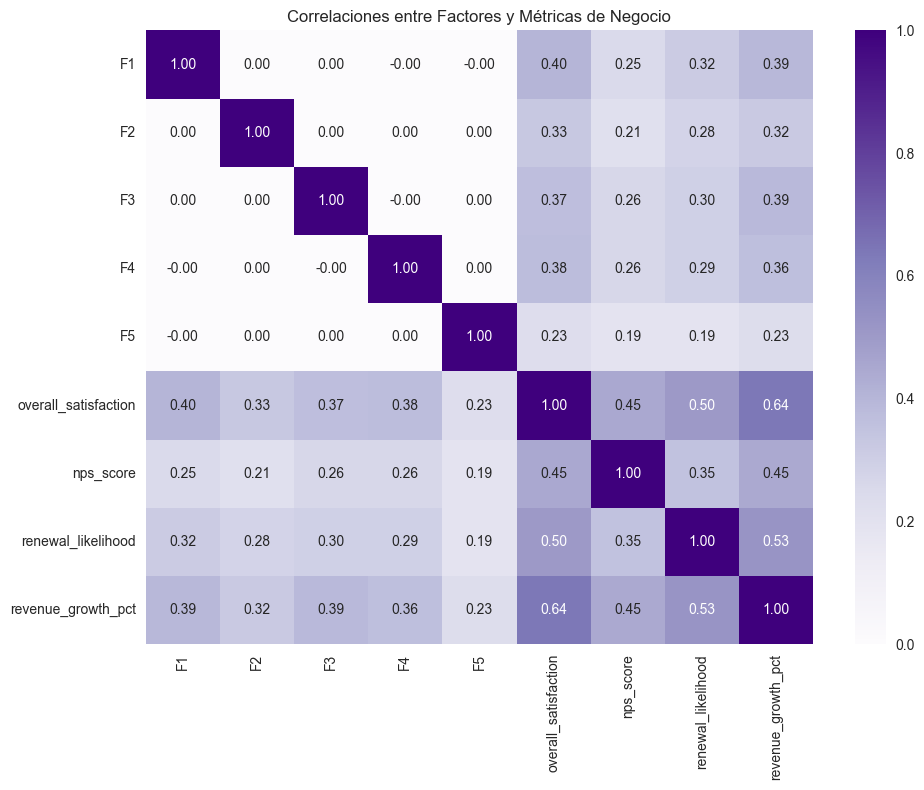

In [24]:
plt.figure(figsize=(10, 8))
corr_matrix = df_scores.corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="Purples",
    vmin=0, vmax=1
)

plt.title("Correlaciones entre Factores y Métricas de Negocio")
plt.tight_layout()
plt.show()


## 5. Modelo Predictivo: Regresión Lineal con los 5 Factores

El objetivo es cuantificar el impacto directo de cada factor en la satisfacción general del cliente (overall_satisfaction).
La regresión permite estimar qué tan importante es cada componente del servicio, controlando por los demás.

## 5.1 Ajuste del modelo de regresión

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = df_scores[["F1", "F2", "F3", "F4", "F5"]]
y = df_scores["overall_satisfaction"]

modelo = LinearRegression()
modelo.fit(X, y)

y_pred = modelo.predict(X)

print("R²:", r2_score(y, y_pred))
print("Coeficientes β:", modelo.coef_)
print("Intercepto:", modelo.intercept_)


R²: 0.6024036175570822
Coeficientes β: [0.33072268 0.26853792 0.30041188 0.30944988 0.18786737]
Intercepto: 4.125588235294118


## 5.2 Visualización de los coeficientes

C:\Users\atave\AppData\Local\Temp\ipykernel_18776\2219936262.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_series.index, y=coef_series.values, palette="Blues_d")


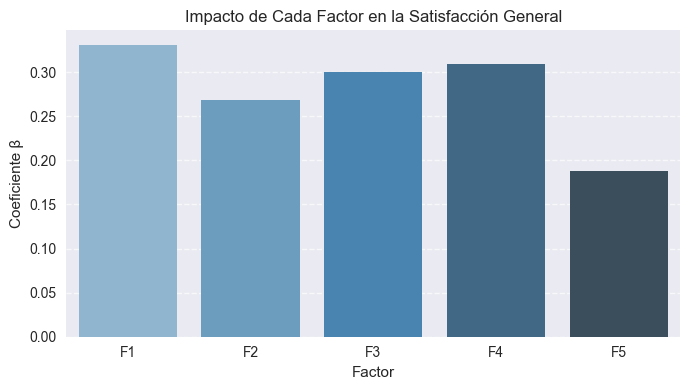

F1    0.330723
F2    0.268538
F3    0.300412
F4    0.309450
F5    0.187867
dtype: float64

In [26]:
coef_series = pd.Series(modelo.coef_, index=X.columns)

plt.figure(figsize=(7, 4))
sns.barplot(x=coef_series.index, y=coef_series.values, palette="Blues_d")
plt.title("Impacto de Cada Factor en la Satisfacción General")
plt.ylabel("Coeficiente β")
plt.xlabel("Factor")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

coef_series
